## Imports

In [1]:
import lenstronomy # runs with v0.9.2

lenstronomy.__version__

'0.9.2'

In [2]:
import gc
gc.collect()

0

In [3]:
import numpy as np
import os
import pickle
import copy
import time
import h5py
from pprint import pprint
from tqdm import tqdm_notebook, tnrange
import getdist
import seaborn as sns
import matplotlib.pyplot as plt

import lenstronomy.Util.util as util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
import lenstronomy.Plots.output_plots as out_plot
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Analysis.lens_analysis import LensAnalysis
from lenstronomy.Analysis.lens_properties import LensProp
from lenstronomy.Plots.output_plots import ModelPlot
import lenstronomy.Util.mask as mask_util
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.LensModel.lens_model import LensModel
import lenstronomy.Util.class_creator as class_creator

cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print(base_path)

/Users/ajshajib/Research/time_delay_cosmography/J0408/DESJ0408_time_delay_cosmography


## Load external convergence

### power-law

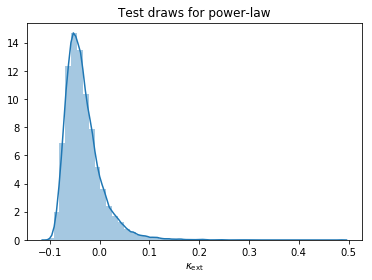

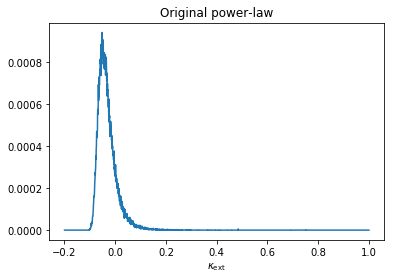

In [4]:
from lenstronomy.Util.prob_density import Approx

kappa_pl_file = '../data/kappahist_0408_measured_5innermask_nobeta_removehandpicked_zgap-1.0_-1.0_powerlaw_120_gal_120_gamma_120_oneoverr_45_gal_45_oneoverr_22.5_med_increments2_2_2_2_2_shearwithoutprior.cat'
output_pl = np.loadtxt(kappa_pl_file)

kappa_list = np.linspace(-0.2+0.0003, 1-0.0003, len(output_pl))

pdf_list_pl = output_pl

pdf_approx_pl = Approx(kappa_list, pdf_list_pl)

pdf_draw_pl = pdf_approx_pl.draw(n=50000)

sns.distplot(pdf_draw_pl)
plt.title('Test draws for power-law')
plt.xlabel(r'$\kappa_{\rm ext}$')
plt.show()


plt.plot(kappa_list, output_pl)
plt.title('Original power-law')
plt.xlabel(r'$\kappa_{\rm ext}$')
plt.show()

mean_kappa_pl = np.sum(kappa_list*output_pl) / np.sum(output_pl)

std_kappa = 'test'

def draw_kappa_pl(n=1):
    return pdf_approx_pl.draw(n=n)

### composite

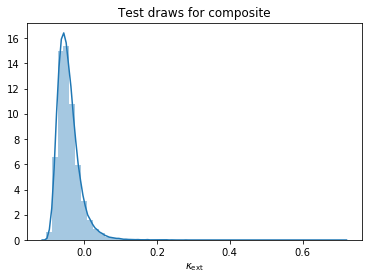

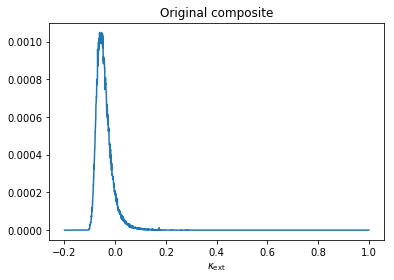

In [5]:
from lenstronomy.Util.prob_density import Approx

kappa_comp_file = '../data/kappahist_0408_measured_5innermask_nobeta_removehandpicked_zgap-1.0_-1.0_composite_120_gal_120_gamma_120_oneoverr_45_gal_45_oneoverr_22.5_med_increments2_2_2_2_2_shearwithoutprior.cat'
output_comp = np.loadtxt(kappa_comp_file)

kappa_list = np.linspace(-0.2+0.0003, 1-0.0003, len(output_comp))

pdf_list_comp = output_comp

pdf_approx_comp = Approx(kappa_list, pdf_list_comp)

pdf_draw_comp = pdf_approx_comp.draw(n=50000)

sns.distplot(pdf_draw_comp)
plt.title('Test draws for composite')
plt.xlabel(r'$\kappa_{\rm ext}$')
plt.show()


plt.plot(kappa_list, output_comp)
plt.title('Original composite')
plt.xlabel(r'$\kappa_{\rm ext}$')
plt.show()

mean_kappa_comp = np.sum(kappa_list*output_comp) / np.sum(output_comp)

std_kappa = 'test'

def draw_kappa_comp(n=1):
    return pdf_approx_comp.draw(n=n)

In [6]:
def convolve_k_ext(pdf, model_type):
    """
    """
    #return pdf
    if model_type == 'powerlaw':
        func = draw_kappa_pl
    elif model_type == 'composite':
        func = draw_kappa_comp
    else:
        raise NotImplementedError
        
    num_samples = len(pdf[0])
    
    k_ext_dist = func(num_samples)
    
    #print(len(k_ext_dist), 'len')
    
    return pdf / (1. - k_ext_dist)

## Load files

In [7]:
dir_prefix = '../model_posteriors/lens_models/'
dir_suffix = '_mod_out.txt'

powerlaw_output_files = [
    '0408_run1001_0_0_0_0_0_1_1_0',
    '0408_run902_0_0_1_0_0_1_1_0',
    '0408_run903_0_0_0_1_0_1_1_0',
    '0408_run904_0_0_1_1_0_1_1_0',
    
    '0408_run905_0_1_0_0_0_1_1_0',
    '0408_run1006_0_1_1_0_0_1_1_0',
    '0408_run907_0_1_0_1_0_1_1_0',
    '0408_run908_0_1_1_1_0_1_1_0',
    
                 
    '0408_run909_0_2_0_0_0_1_1_0',
    '0408_run910_0_2_1_0_0_1_1_0',
    '0408_run911_0_2_0_1_0_1_1_0',
    '0408_run912_0_2_1_1_0_1_1_0'
]

composite_output_files = [
    '0408_run1013_1_0_0_0_0_1_1_0', 
    '0408_run1014_1_0_1_0_0_1_1_0', 
    '0408_run915_1_0_0_1_0_1_1_0',
    '0408_run916_1_0_1_1_0_1_1_0', 

    '0408_run917_1_1_0_0_0_1_1_0',
    '0408_run918_1_1_1_0_0_1_1_0',
    '0408_run919_1_1_0_1_0_1_1_0',
    '0408_run920_1_1_1_1_0_1_1_0',

    '0408_run921_1_2_0_0_0_1_1_0',
    '0408_run922_1_2_1_0_0_1_1_0',
    '0408_run923_1_2_0_1_0_1_1_0',
    '0408_run924_1_2_1_1_0_1_1_0'
]

## Class to load model outputs

In [8]:
import sys
sys.path.insert(0, 'process_output')

# import the class than contains post-processing routines
from output_class import *

In [9]:
# functions for blinding/unblinding

def blind(pdf, get_mean=False, mean=None):
    """
    Blind a posterior PDF.
    """
    if mean is None:
        mean = np.mean(np.array(pdf), axis=1)
        
    #print(mean.shape)
        
    if get_mean:
        return np.array(pdf)/mean[:, np.newaxis] - 1., mean
    else:
        return np.array(pdf)/mean[:, np.newaxis] - 1.
    
    
from astropy.cosmology import FlatLambdaCDM

z_l = 0.597 #0.745 #0.597
z_s = 2.375 #1.789 #2.375

cosmo_fid = FlatLambdaCDM(H0=70., Om0=0.3)
D_d_fid = cosmo_fid.angular_diameter_distance(z_l).value
D_s_fid = cosmo_fid.angular_diameter_distance(z_s).value
D_ds_fid = cosmo_fid.angular_diameter_distance_z1z2(z_l, z_s).value

D_dt_fid = (1+z_l) * D_d_fid * D_s_fid / D_ds_fid

def blindno(pdf, get_mean=False, mean=None):
    """
    Do not blind a posterior PDF.
    """
    if get_mean:
        return pdf * np.array([D_dt_fid, D_d_fid])[:, np.newaxis], None
    else:
        return pdf * np.array([D_dt_fid, D_d_fid])[:, np.newaxis]
    
    if mean is None:
        mean = np.mean(np.array(pdf), axis=1)
        
    print(mean.shape)
        
    if get_mean:
        return np.array(pdf)/mean[:, np.newaxis] - 1., mean
    else:
        return np.array(pdf)/mean[:, np.newaxis] - 1.

## Load power-law files

In [10]:
powerlaw_models = []

# create model output instances
for model_id in powerlaw_output_files: #[-2:]:
    powerlaw_models.append(ModelOutput(model_id, "powerlaw", dir_prefix, dir_suffix, is_test=False))
    
# if first time running, computes time delays, else simply load from pre-saved files
# for model in powerlaw_models:
#     print(model.get_num_samples())
#     model.compute_model_time_delays()

In [11]:
for model in powerlaw_models:
    model.load_velocity_dispersion(model.model_id, '../model_posteriors/velocity_dispersion/vd_', dir_suffix, 500)

In [12]:
for model in powerlaw_models:
    model.load_time_delays(model.model_id, '../model_posteriors/time_delays/td_', dir_suffix)

In [13]:
# Get PL model weights
logzs = []

for model in powerlaw_models:
    logzs.append(model.logZ)
     
pl_weights = get_relative_weights(logzs, 24.*np.sqrt(2.), sigma_model=435.5438725503422)
logzs, pl_weights

('sigma_mmodel:', 435.5438725503422)


([-25087.1684558,
  -25231.7743215,
  -25577.6646348,
  -26469.2974254,
  -25317.2328131,
  -25420.6224642,
  -26551.4985315,
  -25624.1795442,
  -25215.4534651,
  -25449.6951442,
  -26432.4483025,
  -25656.1403792],
 array([1.00000000e+00, 7.40905961e-01, 2.62334936e-01, 1.46417471e-03,
        5.99513091e-01, 4.46735574e-01, 8.61598590e-04, 2.19874955e-01,
        7.71299966e-01, 4.08227043e-01, 2.04190959e-03, 1.93810026e-01]))

In [14]:
pl_combined = CombinedModels()

In [15]:
pl_combined.combine_powerlaw_models(powerlaw_models, pl_weights, 10000)

In [16]:
sampled_k_ext = draw_kappa_pl(len(pl_combined.powerlaw_time_delays))

sampled_k_ext.shape

(46466,)

In [17]:
pl_combined.model_time_delays = pl_combined.powerlaw_time_delays * (1 - sampled_k_ext)[:, np.newaxis]
pl_combined.model_velocity_dispersion = pl_combined.powerlaw_velocity_dispersion * np.sqrt(1 - sampled_k_ext)[:, np.newaxis]

In [18]:
pl_combined.populate_Ddt_Dsds(Ddt_low=0., Ddt_high=150./70., Dsds_low=0.35, Dsds_high=1.35, sample_multiplier=1000)

((46466000, 4), (1, 4))
(46466000, 4)
(46466000, 4)
(46466000,)


In [19]:
pl_cobm_dist, _ = pl_combined.sample_Ddt_Dd(num_sample=30000)
pl_combined.cleanup()

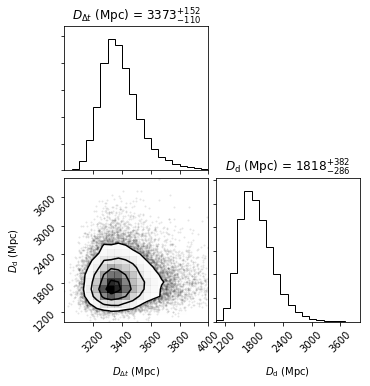

In [20]:
import corner

# unblinded posterior for power-law only
corner.corner(blindno(pl_cobm_dist).T,
              range=[[3000, 4000], [1000, 4000]],
              labels=[r'$D_{\Delta t}$ (Mpc)', r'$D_{\rm d}$ (Mpc)'],
              show_titles=True, title_fmt='.0f', 
             );

## Load composite files

In [21]:
composite_models = []

# create model output instances
for model_id in composite_output_files: #[-2:]:
    composite_models.append(ModelOutput(model_id, "composite", dir_prefix, dir_suffix, is_test=False))
    
# below computes time delays if running first time
# for model in powerlaw_models:
#     print(model.get_num_samples())
#     model.compute_model_time_delays()

In [22]:
for model in composite_models:
    model.load_velocity_dispersion(model.model_id, '../model_posteriors/velocity_dispersion/vd_', dir_suffix, 500)

In [23]:
for model in composite_models:
    model.load_time_delays(model.model_id, '../model_posteriors/time_delays/td_', dir_suffix)

In [24]:
# Get composite model weights
logzs = []

for model in composite_models:
    logzs.append(model.logZ)
     
comp_weights = get_relative_weights(logzs, 24.*np.sqrt(2.), sigma_model=1209.5438546808184)
logzs, comp_weights

('sigma_mmodel:', 1209.5438546808184)


([-25146.6472169,
  -25120.7550762,
  -26540.6784679,
  -27073.0340553,
  -25155.0922771,
  -25054.9268186,
  -25481.8916396,
  -29003.592058,
  -25292.0778431,
  -25154.7717078,
  -25252.3961996,
  -25985.2707486],
 array([0.93985397, 0.95507279, 0.21894655, 0.09527076, 0.93155225,
        1.        , 0.72167207, 0.00106143, 0.84165596, 0.93214463,
        0.86850111, 0.44086531]))

In [25]:
comp_combined = CombinedModels()

In [26]:
comp_combined.combine_composite_models(composite_models, comp_weights, 6000)

In [27]:
sampled_k_ext_comp = draw_kappa_comp(len(comp_combined.composite_time_delays))

sampled_k_ext_comp.shape

(47675,)

In [28]:
comp_combined.model_time_delays = comp_combined.composite_time_delays * (1 - sampled_k_ext_comp)[:, np.newaxis]
comp_combined.model_velocity_dispersion = comp_combined.composite_velocity_dispersion * np.sqrt(1 - sampled_k_ext_comp)[:, np.newaxis]

In [29]:
comp_combined.populate_Ddt_Dsds(Ddt_low=0., Ddt_high=150./70., Dsds_low=0.35, Dsds_high=1.35, sample_multiplier=1000)
comp_cobm_dist, _ = comp_combined.sample_Ddt_Dd(num_sample=30000)
comp_combined.cleanup()

((47675000, 4), (1, 4))
(47675000, 4)
(47675000, 4)
(47675000,)


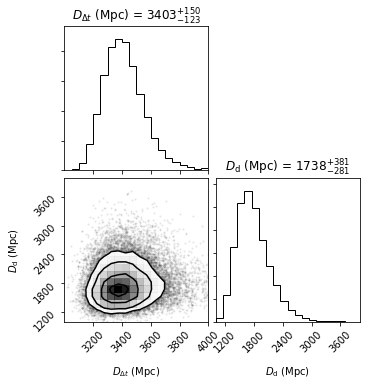

In [30]:
# unblinded posterior for composite only
corner.corner(blindno(comp_cobm_dist).T,
              range=[[3000, 4000], [1000, 4000]],
              labels=[r'$D_{\Delta t}$ (Mpc)', r'$D_{\rm d}$ (Mpc)'],
              show_titles=True, title_fmt='.0f', 
             );

## all combined


In [31]:
all_combined = CombinedModels()

all_combined.combine_powerlaw_models(powerlaw_models, pl_weights, 5000)
all_combined.combine_composite_models(composite_models, comp_weights, 3000)

sampled_k_ext_pl = draw_kappa_comp(len(all_combined.powerlaw_time_delays))
all_combined.powerlaw_time_delays *= (1 - sampled_k_ext_pl)[:, np.newaxis]
all_combined.powerlaw_velocity_dispersion *= np.sqrt(1 - sampled_k_ext_pl)[:, np.newaxis]

sampled_k_ext_comp = draw_kappa_comp(len(all_combined.composite_time_delays))
all_combined.composite_time_delays *= (1 - sampled_k_ext_comp)[:, np.newaxis]
all_combined.composite_velocity_dispersion *= np.sqrt(1 - sampled_k_ext_comp)[:, np.newaxis]

In [32]:
all_combined.combine_powerlaw_composite(num_sample=15000)

In [33]:
all_combined.populate_Ddt_Dsds(Ddt_low=0., Ddt_high=150./70., Dsds_low=0.35, Dsds_high=1.85, sample_multiplier=1000)

((30000000, 4), (1, 4))
(30000000, 4)
(30000000, 4)
(30000000,)


In [34]:
all_comb_dist, indices = all_combined.sample_Ddt_Dd(num_sample=20000)
all_combined.cleanup()

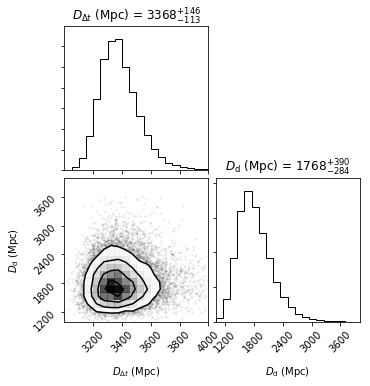

In [35]:
# unblinded posterior for combined posterior from power-law and composite
corner.corner(blindno(all_comb_dist).T,
              range=[[3000, 4000], [1000, 4000]],
              labels=[r'$D_{\Delta t}$ (Mpc)', r'$D_{\rm d}$ (Mpc)'],
              show_titles=True, title_fmt='.0f', 
             );

## cosmology

In [36]:
from scipy.stats import gaussian_kde
from lenstronomy.Cosmo.kde_likelihood import KDELikelihood


transform_dist = all_comb_dist * np.array([D_dt_fid, D_d_fid])[:, np.newaxis]

kde = KDELikelihood(transform_dist[1], transform_dist[0],
                    bandwidth=20
                   )


def log_likelihood(params):
    h0, om_m = params
    cosmo = FlatLambdaCDM(H0=h0, Om0=om_m)
    D_d = cosmo.angular_diameter_distance(z_l).value
    D_s = cosmo.angular_diameter_distance(z_s).value
    D_ds = cosmo.angular_diameter_distance_z1z2(z_l, z_s).value
    
    D_d_r =  D_d
    D_dt_r = (1+z_l)*(D_d * D_s / D_ds)
    
    return kde.logLikelihood(D_d_r, D_dt_r)


def log_prior(params):
    h0, om_m = params
    
    if not 0. < h0 < 150.:
        return -np.inf
    
    if not 0.05 < om_m < 0.5:
        return -np.inf
    
    return 0.


def log_probability(params):
    prior = log_prior(params)
    
    if not np.isinf(prior):
        return log_likelihood(params) + prior
    else:
        return prior

In [37]:
import emcee

nwalkers = 30
ndim = 2
pos = np.random.normal(loc=[70., 0.3], size=[nwalkers, ndim], scale=[1, 5e-2])

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
state = sampler.run_mcmc(pos, 1000);

/Users/ajshajib/Dropbox/PyCharm Projects/lenstronomy/lenstronomy/Cosmo/kde_likelihood.py:43: RuntimeWarning: divide by zero encountered in log
  logL = np.log(density)


In [38]:
sampler.reset()
sampler.run_mcmc(state, 2000);

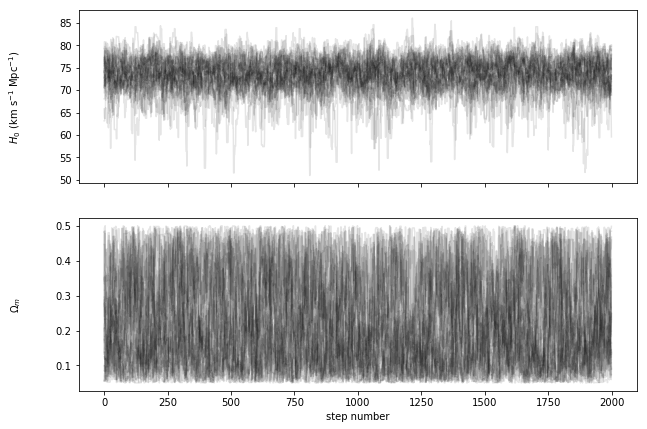

In [39]:
import copy

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = copy.deepcopy(sampler.chain)

#samples[:, :, 0] -= np.mean(samples[:, :, 0])
#samples[:, :, 1] -= np.median(samples[:, :, 1])

labels = [r"$H_0$ (km s$^{-1}$ Mpc$^{-1}$)", r"$\Omega_m$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i].T, "k", alpha=0.1)
    #ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

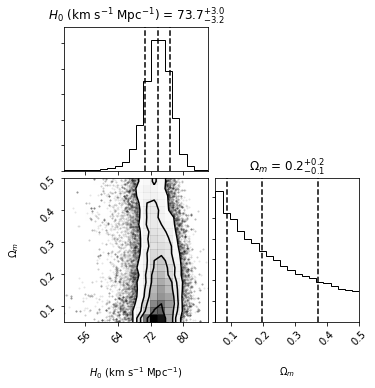

In [40]:
corner.corner(samples.reshape(-1, 2), quantiles=[.16, .50, .84], show_titles=True, labels=labels,
              title_fmt='.1f'
             );